# Python interface for DENISE-Black-Edition package

**DENISE Black Edition implements 2D time-domain isotropic (visco)elastic finite-difference modeling and full waveform
inversion (FWI) code for P/SV-waves, which Daniel Koehn developed together with André Kurzmann, Denise De Nil and
Thomas Bohlen.**

**Source code**: https://github.com/daniel-koehn/DENISE-Black-Edition

**Manual**: https://danielkoehnsite.files.wordpress.com/2020/06/manual_denise.pdf

----------------------------------------

This Python API was developed by [Ovcharenko Oleg](https://ovcharenkoo.com/), [Vladimir Kazei](https://vkazei.com/) and [Daniel Koehn](https://danielkoehnsite.wordpress.com/). KAUST, 23955, Thuwal, Saudi Arabia, 2020

Based on [PythonIO by Daniel Koehn](https://github.com/daniel-koehn/DENISE-Black-Edition/tree/master/par/pythonIO)

Contacts: oleg.ovcharenko@kaust.edu.sa, vladimir.kazei@kaust.edu.sa, daniel.koehn@ifg.uni-kiel.de

# Demo of modeling and FWI in Marmousi II model

In [24]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import numpy as np
import pyapi_denise as api

## Helpers

In [2]:
def load_bin(p, dims): 
    f = open(p); vp = np.fromfile (f, dtype=np.dtype('float32').newbyteorder ('<')); f.close();
    vp = vp.reshape(*dims); vp = np.transpose(vp); vp = np.flipud(vp); print(f"{vp.shape}"); return vp

def plot_model(v, title='', axis='on', **kwargs): 
    plt.figure(); ax = plt.gca(); im = ax.imshow(np.flipud(v), cmap='RdBu_r', **kwargs); plt.axis(axis); plt.title(title); 
    divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05);plt.colorbar(im, cax=cax); plt.pause(0.001)

def plot_acquisition(v, src=None, rec=None, title='', **kwargs):
    nx=model.nx; nz=model.nz; dx=model.dx; par = {'extent': [0, nx*dx/1000, 0, nz*dx/1000], 'cmap': 'RdBu_r'}; par.update(kwargs);
    plt.figure(); ax = plt.gca(); im = ax.imshow(v/1000, **par); plt.title(title); ax.invert_yaxis(); plt.xlabel('km'); plt.ylabel('km');
    if rec is not None: plt.scatter(rec.x/1000, rec.y/1000, 1, color='m'); 
    if src is not None: plt.scatter(src.x/1000, src.y/1000, 1, color='w'); 
    divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05); plt.colorbar(im, cax=cax, label='km/s'); plt.pause(0.001)

def plot_shot(shot, title='', pclip=1.0):
    vmax = pclip * np.max(np.abs(shot)); vmin = - vmax; plt.figure(); plt.imshow(shot.T, cmap='Greys', vmin=vmin, vmax=vmax); 
    plt.colorbar(); plt.title(title); plt.axis('auto'); plt.pause(0.001)
    
def plot_spectrum(shot, dt, title='', fmax=None):
    ps = np.sum(np.abs(np.fft.fft(shot)) ** 2, axis=-2); freqs = np.fft.fftfreq(len(ps), dt); idx = np.argsort(freqs)
    causal = int(len(ps) // 2); freqs, ps = freqs[idx], ps[idx]; freqs = freqs[-causal:]; ps = ps[-causal:]; freqs = freqs[freqs < (fmax if fmax else np.max(freqs))]; 
    n = len(freqs); plt.figure(); plt.plot(freqs[:n], ps[:n], label=title); plt.xlabel('Frequency (Hz)'); plt.ylabel('Gain'); plt.grid(True);
    
def plot_logs(m1, m2, idx=2):
    plt.figure(); plt.plot(m1.vp[::-1,idx], 'k--'); plt.plot(m1.vs[::-1,idx], 'k--'); plt.plot(m1.rho[::-1,idx], 'k--');
    plt.plot(m2.vp[::-1,idx], label='vp'); plt.plot(m2.vs[::-1,idx], label='vs'); plt.plot(m2.rho[::-1,idx], label='rho'); plt.legend() 
    
def is_empty(p): return False if (os.path.exists(p) and [f for f in os.listdir(p) if f != '.gitignore']) else True

# Init Denise API

In [3]:
denise_root = './'
d = api.Denise(denise_root, verbose=1)

Init Python 3 API for Denise-Black-Edition.
Check binary in ./bin/denise
Parse ./par/DENISE_marm_OBC.inp


## Work directory
Where to output everything

In [4]:
d.save_folder = './outputs/'
d.set_paths()

Print out all parameters. The word in paranthesis is the attribute name for the respective parameter

In [5]:
d.help()

#-----------------------------------------------------------------
#      PARAMETER FILE FOR DENISE BLACK-EDITION
#-----------------------------------------------------------------
# description:
# description/name of the model: Marmousi-II
#
# ------------------ DENISE Mode ---------------------------------
# Operation mode:
(forward_modelling_only=0;FWI=1;RTM=2)_(MODE) = 0
#
# ---------------- DENISE Physics -----------------------------
(2D-PSV=1;2D-AC=2;2D-VTI=3;2D-TTI=4;2D-SH=5)_(PHYSICS) = 1
#
#-------------- Domain Decomposition -----------------------------
number_of_processors_in_x-direction_(NPROCX) = 5
number_of_processors_in_y-direction_(NPROCY) = 3
#
#-------------------- FD order -----------------------------------
# Order of ssg FD coefficients (values: 2, 4, ..., 12)
FD_ORDER = 8
# Maximum relative group velocity error E
# (minimum number of grid points per shortest wavelength is defined by FD_ORDER and E)
# values: 0 = Taylor coefficients
#	  1 = Holberg coeff.: E = 0.

# Marmousi II velocity model

## Load binaries

In [6]:
if is_empty('./par/start/'):
    # Download Marmousi II model
    !wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vp -P ./par/start/
    !wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vs -P ./par/start/
    !wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.rho -P ./par/start/
    # Download initial model for FWI
    !wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vp -P ./par/start/
    !wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vs -P ./par/start/
    !wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.rho -P ./par/start/     

## Read and initialize

(174, 500)
(174, 500)
(174, 500)


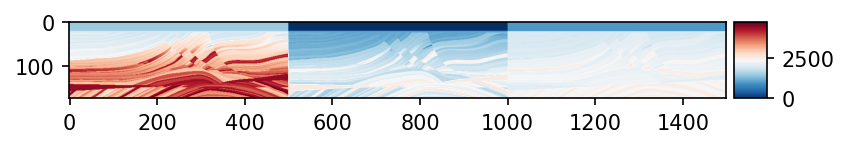

In [7]:
dx = 20.0
vp = load_bin('./par/start/marmousi_II_marine.vp', (500, 174))
vs = load_bin('./par/start/marmousi_II_marine.vs', (500, 174))
rho = load_bin('./par/start/marmousi_II_marine.rho', (500, 174))
plot_model(np.concatenate((vp, vs, rho), 1))

In [8]:
model = api.Model(vp, vs, rho, dx)
print(model)

nz, nx = vp.shape
vplim = {'vmax': model.vp.max()/1000, 'vmin': model.vp.min()/1000}
vslim = {'vmax': model.vs.max()/1000, 'vmin': model.vs.min()/1000}
rholim = {'vmax': model.rho.max()/1000, 'vmin': model.rho.min()/1000}
vlims = {'vp': vplim, 'vs': vslim, 'rho': rholim}

vp:	(174, 500), 1500.0000, 4766.6040 m/s

vs:	(174, 500), 0.0000, 2752.0000 m/s

rho:	(174, 500), 1009.9993, 2626.9998 g/cm3

dx:	20.0000
Size:
	OX:	min 0.0000	max 9980.0000 m
Size:
	OZ:	min 0.0000	max 3460.0000 m


## Acquisition design

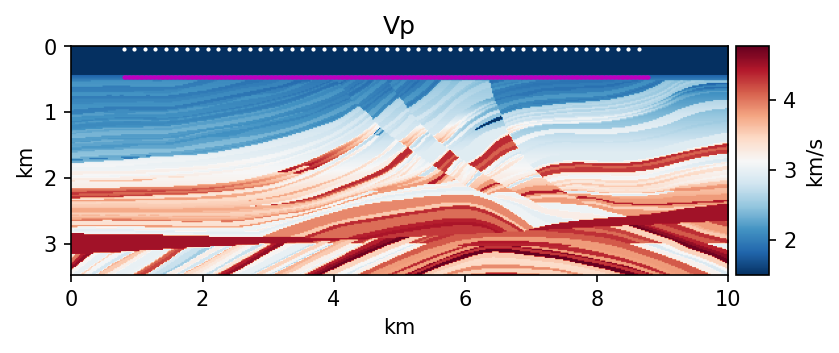

NSRC:	50
NREC:	400


In [9]:
# Receivers
drec = 20.
depth_rec = 460.  # receiver depth [m]
xrec1 = 800.      # 1st receiver position [m]
xrec2 = 8780.     # last receiver position [m]
xrec = np.arange(xrec1, xrec2 + dx, drec)
yrec = depth_rec * (xrec / xrec)

# Sources
dsrc = 160. # source spacing [m]
depth_src = 40.  # source depth [m]
xsrc1 = 800.  # 1st source position [m]
xsrc2 = 8720.  # last source position [m]
xsrc = np.arange(xsrc1, xsrc2 + dx, dsrc)
ysrc = depth_src * xsrc / xsrc

# Wrap into api
rec = api.Receivers(xrec, yrec)
src = api.Sources(xsrc, ysrc)

plot_acquisition(model.vp, src, rec, 'Vp')

print(f'NSRC:\t{len(src)}')
print(f'NREC:\t{len(rec)}')

## Generate true waveforms

Set some runtime parameters which are different from defaults. Check defaults by runnning `help()`

In [10]:
# Parallelization
d.NPROCX = 5
d.NPROCY = 3

# Elastic modeling
d.PHYSICS = 1

### Run forward modeling

In [11]:
d.forward(model, src, rec)

Check max source frequency:
	min Vs: 881.0 m/s
	min Vp: 1500.0 m/s
	Number of gridpoints per minimum wavelength = 3.69
	Maximum source wavelet frequency = 11.937669376693767 Hz
Check domain decomposition for parallelization:
	in X-direction, NX % NPROCX, 500 % 5 = 0
	in Y-direction, NY % NPROCY, 174 % 3 = 0
Check elastic ratios:
	Poisson ratio:		0.2816092073917389
	Shear wave velocity:	1602.6331787109375
	Rayleigh velocity:	1479.36697442382
Compute DT from model given as argument
Check stability:
	max Vs: 2752.0  m/s
	max Vp: 4766.60400390625 m/s
	According to the Courant-Friedrichs-Lewy (CFL) criterion
	the maximum time step is DT = 2.20e-03 sec
	Rounded dt = 0.002
Write binaries for
	./outputs/start/model.vp
	./outputs/start/model.vs
	./outputs/start/model.rho
Start simulation for NREC: 400, NSRC: 50, NT: 3000...wait

mpirun -np 15  ./bin/denise  ./outputs/seis.inp ./outputs/seis_fwi.inp

Done. 133.8190381526947 sec.

Check results in ./outputs/su/


### Inspect results
By default, .get_shots() loads all created data files into a list. The `keys` option filters out everythin which doesn't have these substrings in it. In other words, we plot only `_y` component of the wavefield.

Read 54 shots (400, 3000) into list


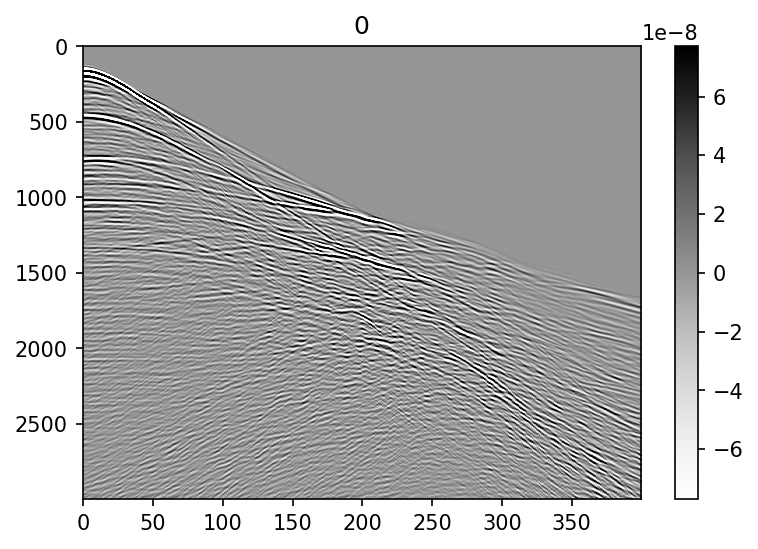

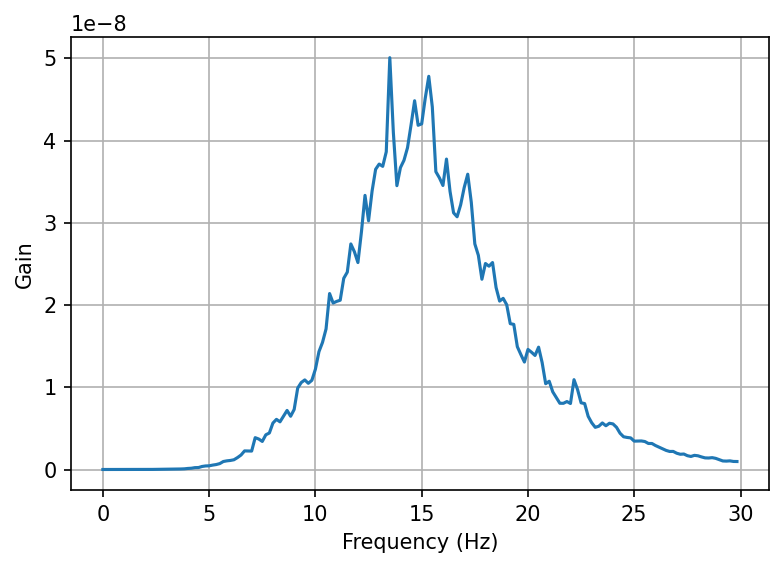

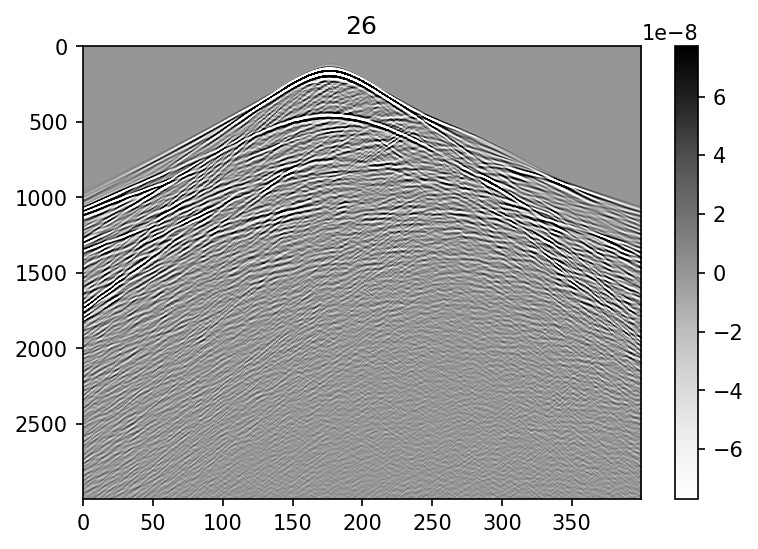

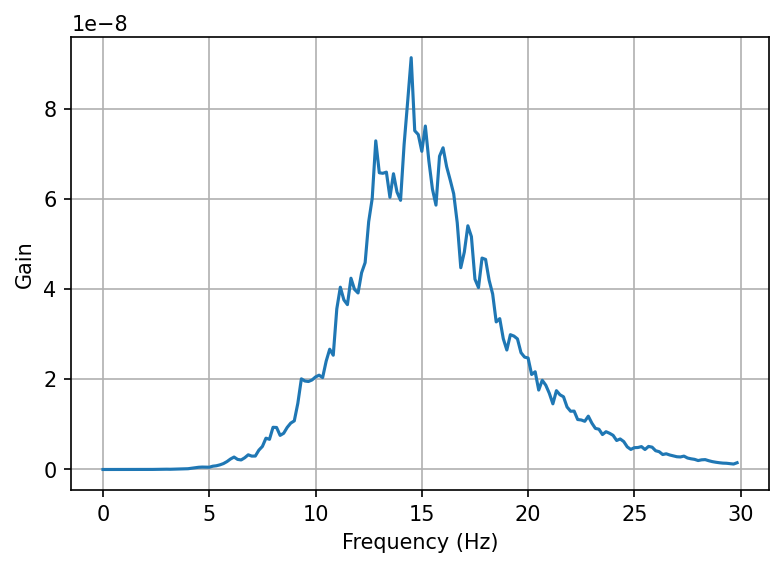

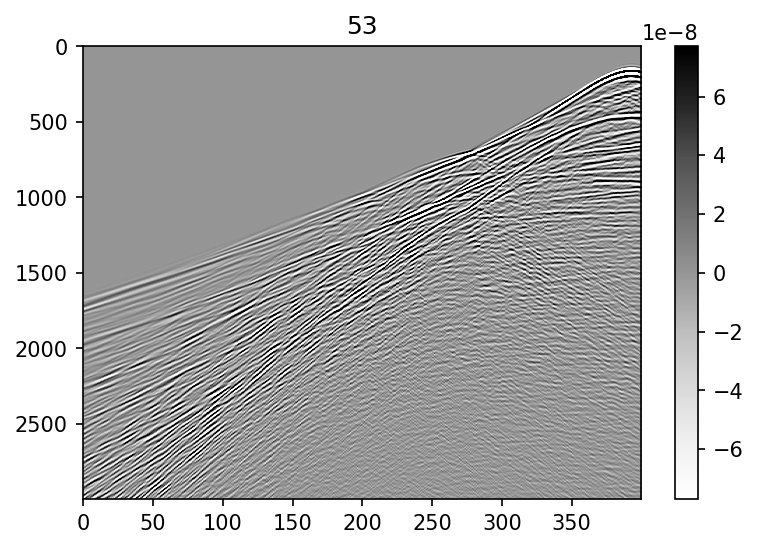

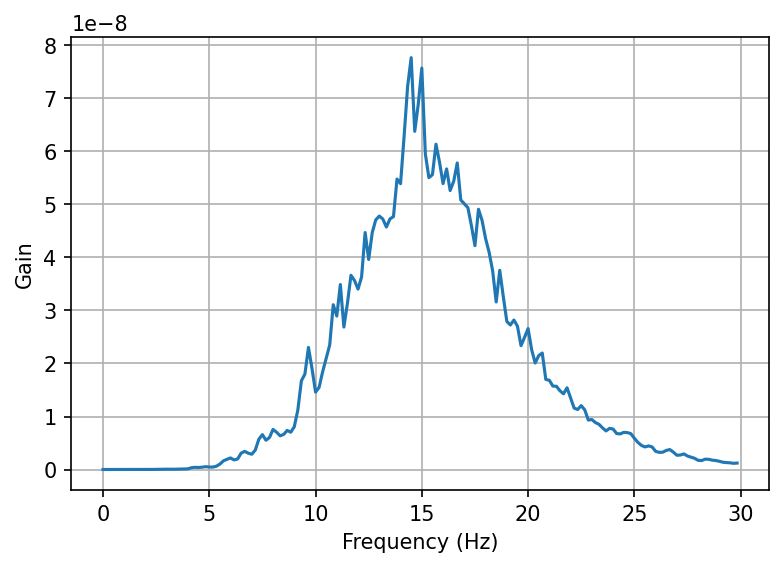

In [12]:
d.verbose = 0    # don't show redundant print outs

shots = d.get_shots(keys=['_y'])
print(f'Read {len(shots)} shots {shots[0].shape} into list')

# Plot 3 shots and their respective power spectra
for i in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 3)]:
    plot_shot(shots[i], pclip=0.05, title=str(i))
    plot_spectrum(shots[i], d.DT, fmax=30); 

# Full-waveform inversion
Invert for elastic properties `vp`, `vs` and `rho`, given `x` and `y` velocity components of wavefield 

## Initial velocity model
Smooth background model with true water bottom and shallow sediments

(174, 500)
(174, 500)
(174, 500)


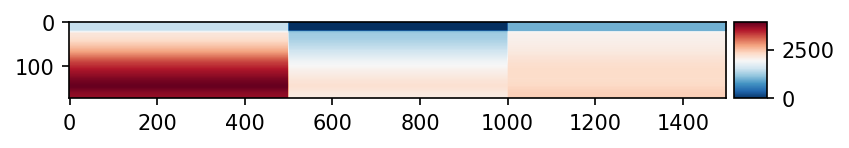

In [13]:
vp = load_bin('./par/start/marmousi_II_start_1D.vp', (500, 174))
vs = load_bin('./par/start/marmousi_II_start_1D.vs', (500, 174))
rho = load_bin('./par/start/marmousi_II_start_1D.rho', (500, 174))
plot_model(np.concatenate((vp, vs, rho), 1))

vp:	(174, 500), 1500.0000, 3916.4761 m/s

vs:	(174, 500), 0.0000, 2261.1787 m/s

rho:	(174, 500), 1009.9993, 2435.5867 g/cm3

dx:	20.0000
Size:
	OX:	min 0.0000	max 9980.0000 m
Size:
	OZ:	min 0.0000	max 3460.0000 m


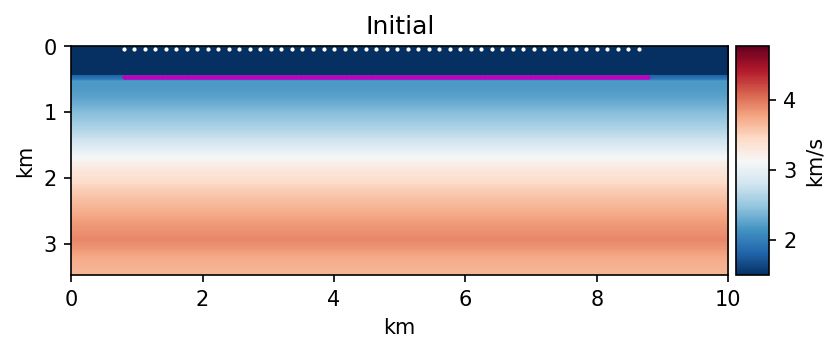

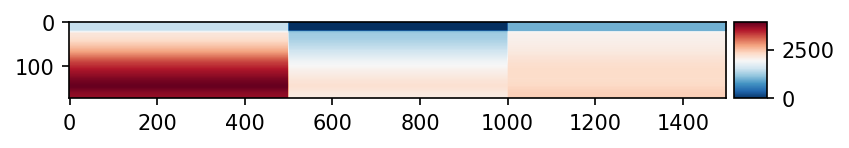

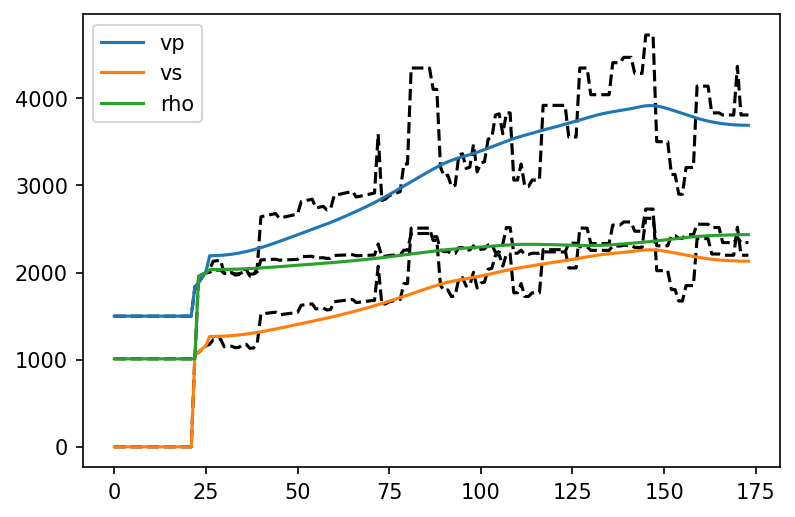

In [14]:
model_init = api.Model(vp, vs, rho, dx)
print(model_init)

log_idx = int(model_init.nx / 2)
plot_acquisition(model_init.vp, src, rec, title='Initial', **vplim)
plot_model(np.concatenate((model_init.vp, model_init.vs, model_init.rho), 1))
plot_logs(model, model_init, log_idx)

## Stages of inversion
Use default parameters, except high- and low-pass corner frequencies of Butterworth filter

In [15]:
d.fwi_stages = []
for i, freq in enumerate([2, 5, 10, 20]):
    d.add_fwi_stage(fc_low=0.0, fc_high=freq)
    print(f'Stage {i+1}:\n\t{d.fwi_stages[i]}\n')

Stage 1:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 2, 'ORDER': 6, 'TIME_WIN': 0, 'GAMMA': 20, 'TWIN-': 0.0, 'TWIN+': 0.0, 'INV_VP_ITER': 0, 'INV_VS_ITER': 0, 'INV_RHO_ITER': 0, 'INV_QS_ITER': 0, 'SPATFILTER': 0, 'WD_DAMP': 0.5, 'WD_DAMP1': 0.5, 'EPRECOND': 3, 'LNORM': 2, 'STF': 0, 'OFFSETC_STF': -4.0, 'EPS_STF': 0.1, 'NORMALIZE': 0, 'OFFSET_MUTE': 0, 'OFFSETC': 10, 'SCALERHO': 0.5, 'SCALEQS': 1.0, 'ENV': 1, 'N_ORDER': 0}

Stage 2:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 5, 'ORDER': 6, 'TIME_WIN': 0, 'GAMMA': 20, 'TWIN-': 0.0, 'TWIN+': 0.0, 'INV_VP_ITER': 0, 'INV_VS_ITER': 0, 'INV_RHO_ITER': 0, 'INV_QS_ITER': 0, 'SPATFILTER': 0, 'WD_DAMP': 0.5, 'WD_DAMP1': 0.5, 'EPRECOND': 3, 'LNORM': 2, 'STF': 0, 'OFFSETC_STF': -4.0, 'EPS_STF': 0.1, 'NORMALIZE': 0, 'OFFSET_MUTE': 0, 'OFFSETC': 10, 'SCALERHO': 0.5, 'SCALEQS': 1.0, 'ENV': 1, 'N_ORDER': 0}

Stage 3:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 10, 'ORDER': 6, 'TIME_WIN': 0, 'GAMMA': 20, 'TWIN-':

## Run inversion

In [16]:
print(f'Target data: {d.DATA_DIR}')
d.fwi(model_init, src, rec)

Target data: ./outputs/su/seis
mpirun -np 15  ./bin/denise  ./outputs/seis.inp ./outputs/seis_fwi.inp

Done. 71951.50960588455 sec.

Check results in ./outputs/su/


# Visualize FWI outputs
It will not hurt to make sure that paths and model dims are up to date. This is necessary when you only want to plot pictures, without running modeling or FWI

In [17]:
d.set_paths()
d.set_model(model_init)

## True model

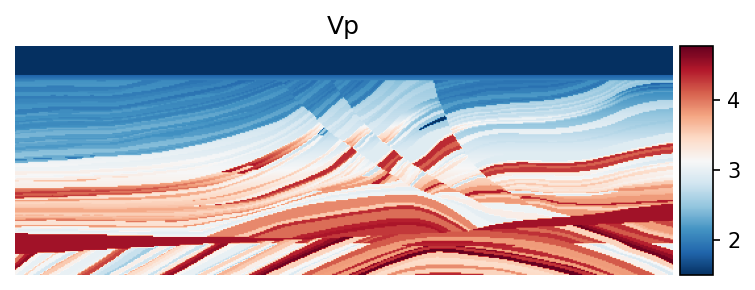

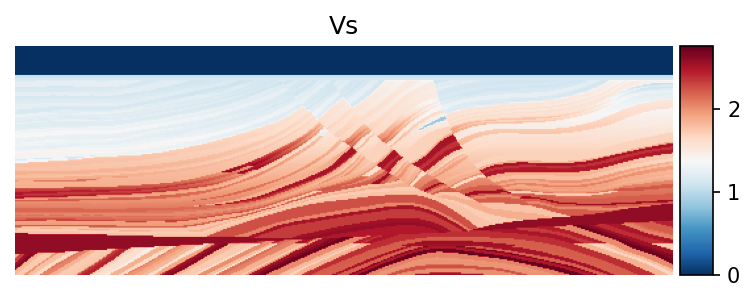

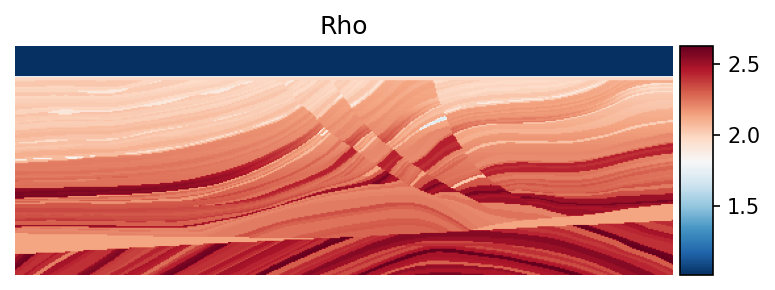

In [23]:
plot_model(model.vp / 1000, title='Vp', axis='off', **vlims['vp'])
plot_model(model.vs / 1000, title='Vs', axis='off', **vlims['vs'])
plot_model(model.rho / 1000, title='Rho', axis='off', **vlims['rho'])

## Inverted model
The code ouputs inverted models for every elastic property at every FWI stage. Change `vp` to `vs` or `rho` to explore respective outputs

Read models from ./outputs/model with ['vp', 'stage', '.bin']


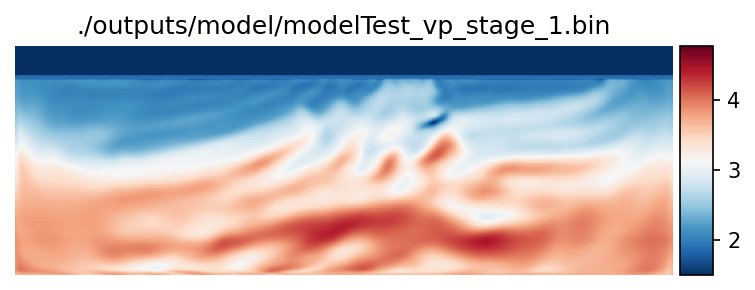

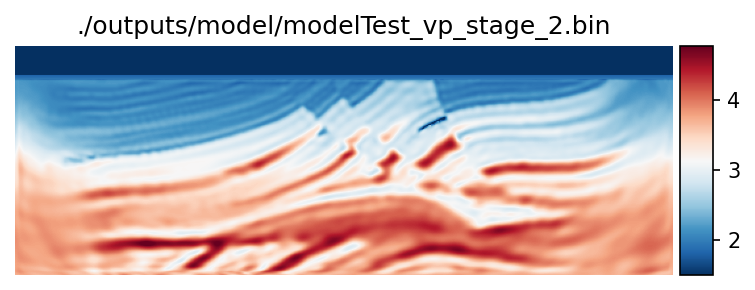

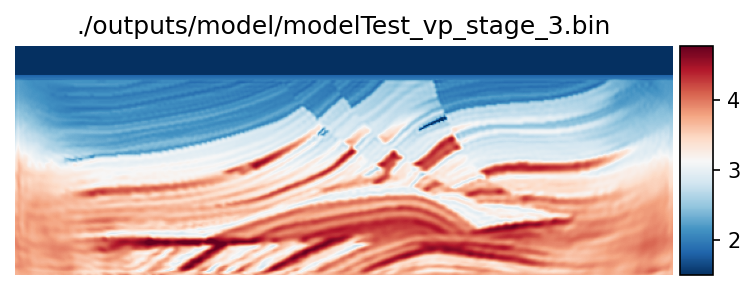

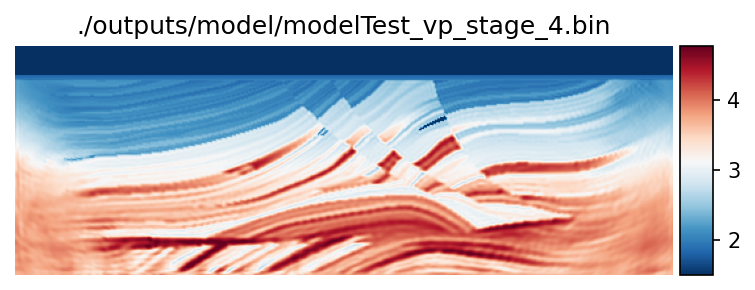

In [22]:
component = 'vp'

models, fnames = d.get_fwi_models([component, 'stage'], return_filenames=True)
for m, f in zip(models, fnames):
    plot_model(m / 1000, title=f, axis='off', **vlims[component])

## Well-logs
Plot logs in true model (dashed) and inverted models (solid) for every inversion stage

Read models from ./outputs/model with ['vp', 'stage', '.bin']
Read models from ./outputs/model with ['vs', 'stage', '.bin']
Read models from ./outputs/model with ['rho', 'stage', '.bin']


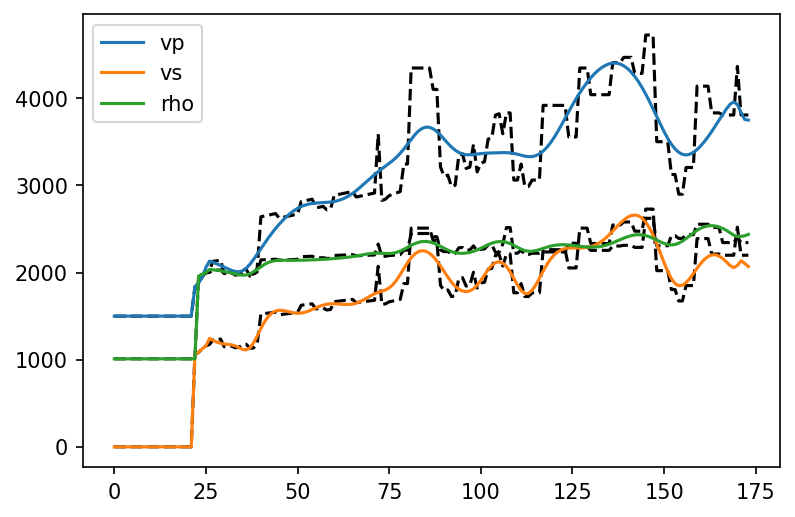

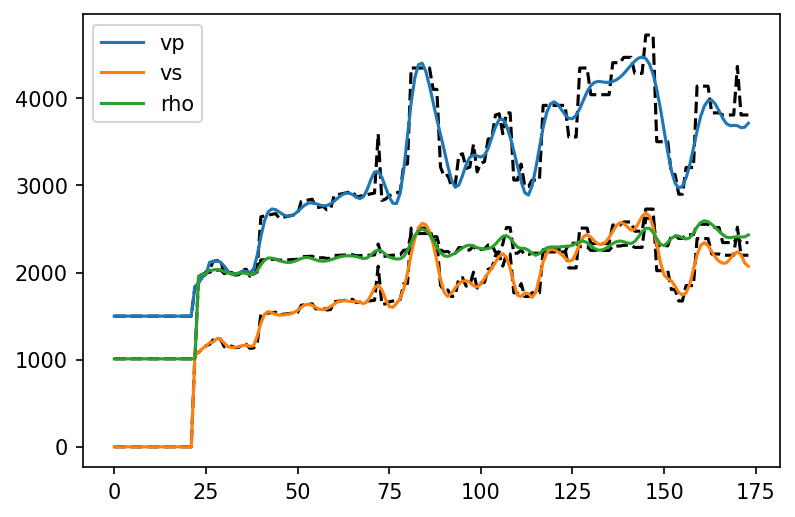

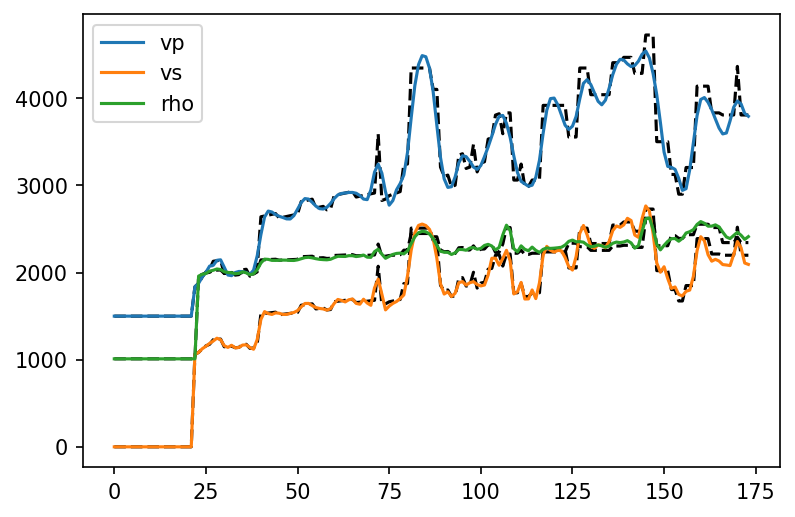

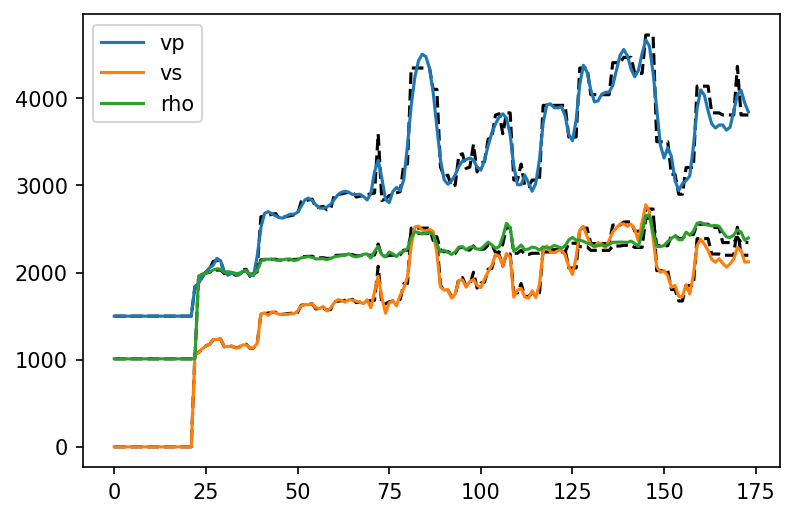

In [20]:
# Load inverted models from all stages
vvr = {'vp': None, 'vs': None, 'rho': None}
for k in vvr.keys():
    vvr[k], fnames = d.get_fwi_models([k, 'stage'], return_filenames=True)

for i in range(len(vvr['vp'])):
    plot_logs(model, api.Model(vvr['vp'][i], vvr['vs'][i], vvr['rho'][i], dx), log_idx)

## Gradients at last stage

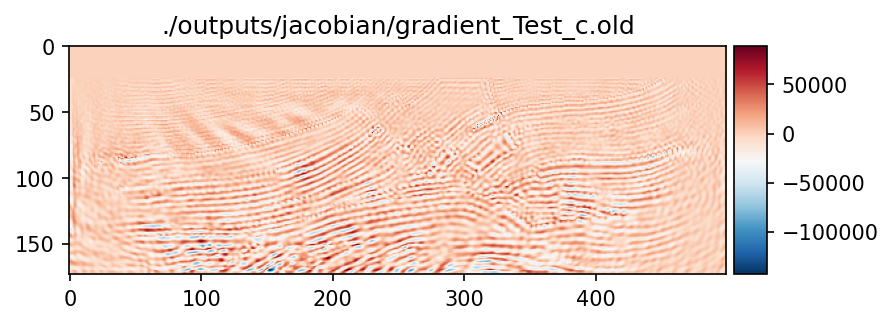

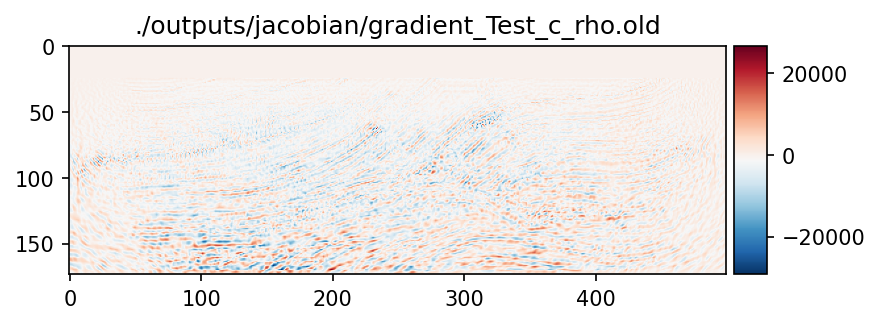

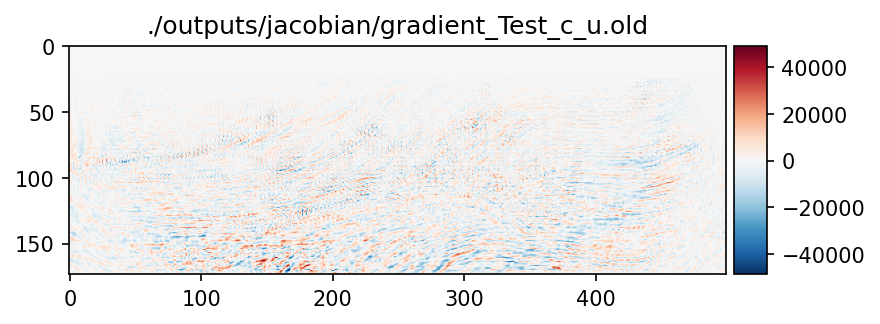

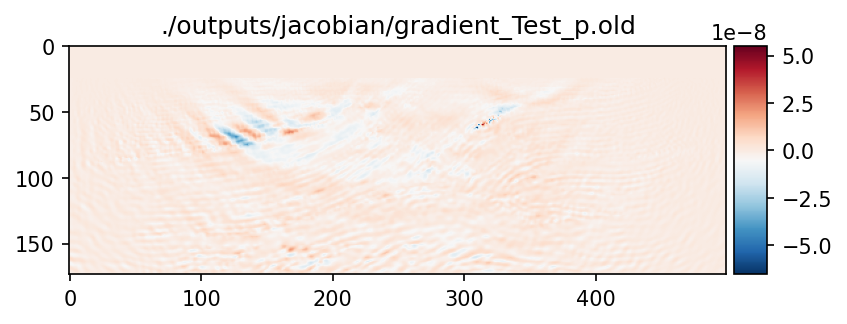

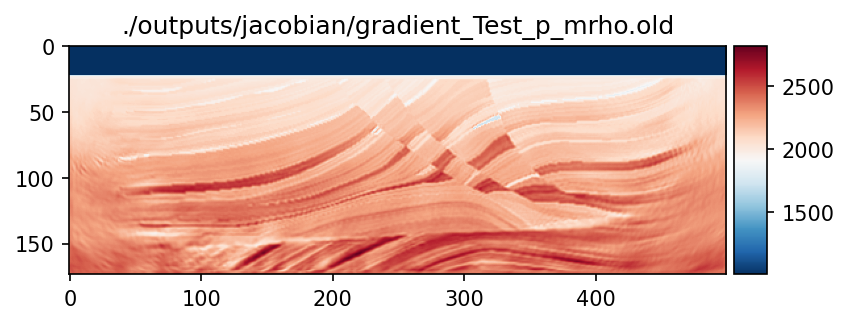

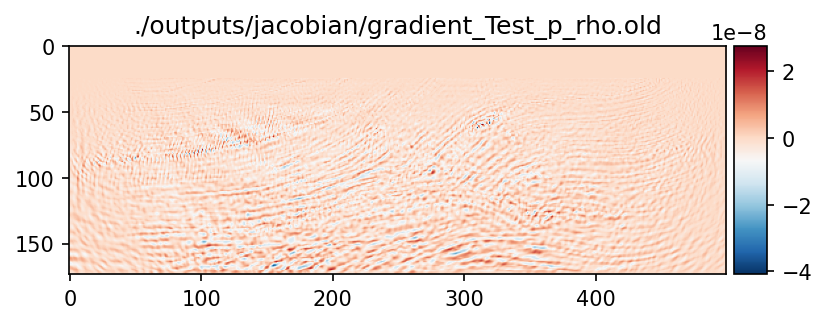

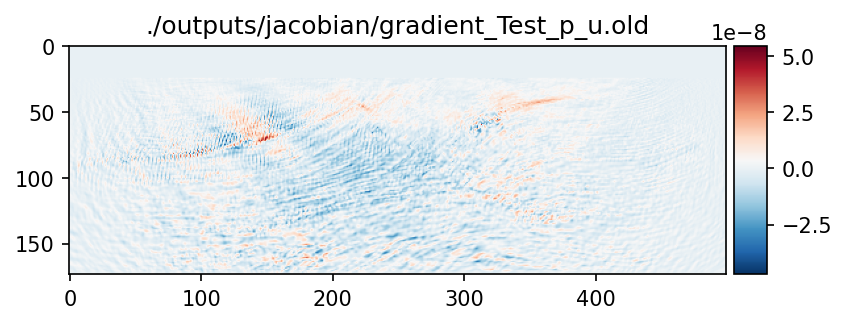

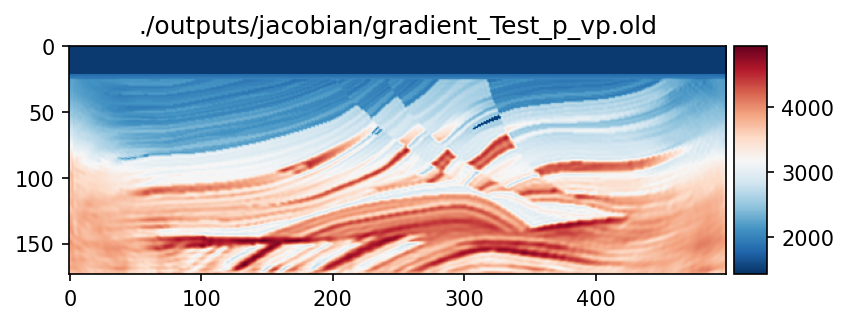

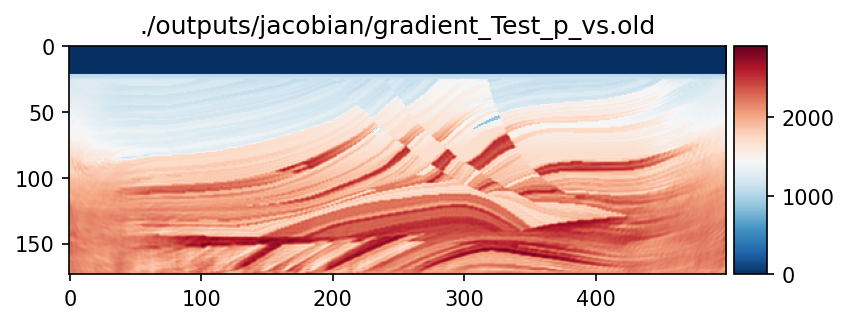

In [21]:
grads, fnames = d.get_fwi_gradients(return_filenames=True)
for g, f in zip(grads, fnames):
    plot_model(g, f)